In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
from tqdm import tqdm
from glob import glob

# Read the file

In [3]:
json_list = sorted(glob("./jsons/*.json"))

In [4]:
# jsons = fsspec.open_files("./test.json")
# with jsons[0] as afile:

ds_list = []
m_list = []
for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", fo=json.load(f), remote_protocol="s3", remote_options={"anon": True}))
#         ds = xr.open_dataset(m, engine="zarr")
#         ds_list.append(ds)

100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


In [5]:
%%time
ds = xr.open_mfdataset(m_list, combine='nested', concat_dim='t',
                       engine='zarr', coords='minimal', 
                       data_vars='minimal', compat='override')

CPU times: user 5.47 s, sys: 316 ms, total: 5.79 s
Wall time: 2min 30s


## Now to do the same calculations/plotting as before

In [6]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [7]:
ds = calc_latlon(ds)

<ipython-input-6-faaad4e12a01>:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


## Unlike reading netCDF from s3fs directly, here doing `.where()` on lat/lon doesn't kill the kernel

In [8]:
%%time
lat1, lat2 = (31, 53)
lon1, lon2 = (-85, -56)

subset = ds.where((ds.lat >= lat1) & (ds.lat <= lat2) & (ds.lon >= lon1) & (ds.lon <= lon2), drop=True)

CPU times: user 1.36 s, sys: 1.04 s, total: 2.4 s
Wall time: 11.6 s


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CPU times: user 10.2 s, sys: 780 ms, total: 11 s
Wall time: 1min 25s


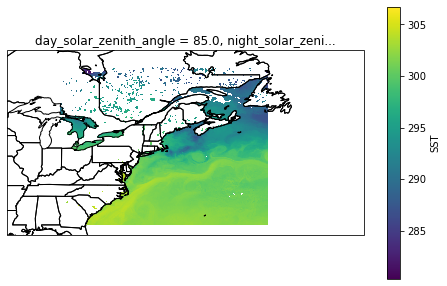

In [9]:
%%time

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
subset.SST.where(subset.DQF==0).mean('t', skipna=True).plot(x="lon", y="lat", ax=ax)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)